In [1]:
from __future__ import print_function
import os
import sys

# Edit this to be the full path to the extracted Spark directory on your computer
# Use "\" on Windows, "/" on OS 10
spark_home = 'C:\Users\mcollins\Desktop\SparkWorkshop\spark-2.1.0-bin-hadoop2.7'

os.environ['SPARK_HOME'] = spark_home
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python', 'lib', 'py4j-0.10.4-src.zip'))

In [2]:
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext()
sqlContext = SQLContext(sc)

In [3]:
comments = sqlContext.read.json("data/hacker_news_100k.json.gz")
comments.count()

100000

In [4]:
comments.printSchema()

root
 |-- _highlightResult: struct (nullable = true)
 |    |-- author: struct (nullable = true)
 |    |    |-- matchLevel: string (nullable = true)
 |    |    |-- matchedWords: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- value: string (nullable = true)
 |    |-- comment_text: struct (nullable = true)
 |    |    |-- matchLevel: string (nullable = true)
 |    |    |-- matchedWords: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- value: string (nullable = true)
 |    |-- story_title: struct (nullable = true)
 |    |    |-- matchLevel: string (nullable = true)
 |    |    |-- matchedWords: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- value: string (nullable = true)
 |    |-- story_url: struct (nullable = true)
 |    |    |-- matchLevel: string (nullable = true)
 |    |    |-- matchedWords: array (nullable = true)
 |    |    |    |-- elemen

In [5]:
comments.show(3)


+--------------------+--------------------+----------+--------------------+--------------------+------------+------------+--------+---------+------+--------+----------+--------------------+--------------------+-----+----+
|    _highlightResult|               _tags|    author|        comment_text|          created_at|created_at_i|num_comments|objectID|parent_id|points|story_id|story_text|         story_title|           story_url|title| url|
+--------------------+--------------------+----------+--------------------+--------------------+------------+------------+--------+---------+------+--------+----------+--------------------+--------------------+-----+----+
|[[none,WrappedArr...|[comment, author_...|       VMG|Because you don&#...|2014-05-30T08:19:34Z|  1401437974|        null| 7820767|  7820656|     1| 7820350|      null|Mark Zuckerberg a...|http://www.mercur...| null|null|
|[[none,WrappedArr...|[comment, author_...|hackerboos|$649 in US<p>$699...|2014-05-30T08:18:47Z|  1401437927|   

In [6]:
comments.select(comments["comment_text"]).show(3)

+--------------------+
|        comment_text|
+--------------------+
|Because you don&#...|
|$649 in US<p>$699...|
|The one I use mos...|
+--------------------+
only showing top 3 rows



The above line is a good oportunity to look at the documentation:

http://spark.apache.org/docs/latest/api/python/pyspark.sql.html

show() is in the DataFrame functions. Or search for "show(n=20" because the show() function is used in a lot of examples.

This is also a good time to introduce the line continuation character "\" which makes reading long commands easier.

In [7]:
comments\
    .select(comments["comment_text"])\
    .show(3, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|comment_text                                                                                                                                                                                                                                                                                                                                                                                              |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Cleaning

From the sample comments, we can see that if we are going to look at what words are in the comments, we will need to remove the HTML tags and we will need to convert HTML entities like "&#x27;" to their characters like "'". There are a number of libraries we could use to do that but we will work with just do a regular expression because Spark is the focus for today.

In [8]:
import re
expression = re.compile(r'<.*?>')
import HTMLParser
parser = HTMLParser.HTMLParser()

def strip_tags(html):
    return parser.unescape(
        expression.sub('', html)
        )
    
print(strip_tags("<b>you&#x27;re a Gator!</b>"))

you're a Gator!


That's a nice little function but how do we run it on a column in the dataframe? And where do we store the results? What we want to do is add a column to the dataframe with text that has no HTML in it. This is called applying a user defined function to your data.

In [9]:
comments_clean = comments.withColumn("comment_clean", 
                                     strip_tags(comments["comment_text"])
                                    )

TypeError: expected string or buffer

Whoops! That didn't work. We wrote a Python function that takes a string and passed it a Spark dataframe column. What we want is to get Spark to do is to run that function for every value in the column with means we have to change our function to something Spark knows how to handle. Fortunately, there's a function to do just that. Notice that the argument to udf() is a function and the return is a function. In Python, functins are first class objects, they're a thing that can be manuipulated, calculated, returned, etc. like other data types.

In [10]:
from pyspark.sql.functions import udf

strip_tags_udf = udf(strip_tags)

comments_clean = comments.withColumn("comment_clean", 
                                     strip_tags_udf(comments["comment_text"])
                                    )

In [11]:
comments_clean\
    .select(comments_clean["comment_clean"])\
    .show(3, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|comment_clean                                                                                                                                                                                                                                                                                                                       |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Because you don't 

# Tokenizing

Today we're going to do some very simple NLP. We'll consider the comments to just be a collection of words. We'll use those words to figure out which posts are most relavent to a search term that we're interested in.

First up is splitting the comments up in to lists of words. At this point we'll introduce the machine learning API:

(Mention ml for dataframes vs older mllib for RRDs)

http://spark.apache.org/docs/latest/api/python/pyspark.ml.html


In [12]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol="comment_clean", outputCol="words")

comments_words = tokenizer.transform(comments_clean)

In [13]:
comments_words\
    .select(comments_words["words"])\
    .show(3, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|words                                                                                                                                                                                                                                                                                                                                                                                             |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
# What are the stop words? http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words

from pyspark.ml.feature import StopWordsRemover
stopWordsRemover = StopWordsRemover(inputCol="words", outputCol="tokens")

comments_tokens = stopWordsRemover.transform(comments_words)

In [15]:
comments_tokens\
    .select(comments_tokens["tokens"])\
    .show(3, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tokens                                                                                                                                                                                                                                                                    |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[don't, rely, political, apparatus, spend, money, wisely.by, way,, nobody, wait, billionaires, anywhere,, want, help, education,, get, it.]                                                     

# Zipf's Law

Zipf's law says that the frequency of a term is inversely proportianal to it's rank ie. the second most common term occurs 1/2 as often as the first; the third most common 1/3 as often; etc. A log-log graph of frequencey vs rank should be a straight line.

Let's count our tokens and graph the counts to see what they look like. Here we're going to use a map-reduce pattern of computation which we're going to express in dataframe functions that look like a SQL statement.

In [16]:
from pyspark.sql.functions import explode

tokens = comments_tokens\
    .select(explode(comments_tokens["tokens"]).alias("token"))\
    .groupBy("token")\
    .count()\
    .orderBy("count", ascending=False)
    
tokens.show(10)

+------+-----+
| token|count|
+------+-----+
|      |73208|
|  it's|23630|
| would|21905|
|  like|21540|
|people|17500|
| don't|17306|
|   one|14924|
| think|13764|
|   get|13410|
|   use|11724|
+------+-----+
only showing top 10 rows



Now how do we graph the frequency against term rank (integer sequence from 1..n)? We have a Spark dataframe but that's not something we can use with graphing tools. But, we can convert it to Pandas.

We'll convert the absolute minimum information to a Pandas dataframe - storage, transfer time.

In [17]:
tokens_pdf = tokens\
    .select(tokens["count"])\
    .toPandas()

In [18]:
tokens_pdf.count()

count    335936
dtype: int64

In [19]:
import numpy as np
tokens_pdf["rank"] = range(1, tokens_pdf.shape[0] + 1)
tokens_pdf["log_rank"] = np.log(tokens_pdf["rank"])
tokens_pdf["log_count"] = np.log(tokens_pdf["count"])
tokens_pdf.head()

,count,rank,log_rank,log_count
0,73208,1,0.000000,11.201060
1,23630,2,0.693147,10.070272
2,21905,3,1.098612,9.994470
3,21540,4,1.386294,9.977667
4,17500,5,1.609438,9.769956


In [20]:
%matplotlib inline

# "conda install seaborn" at a command prompt if you don't have it already
import seaborn as sns

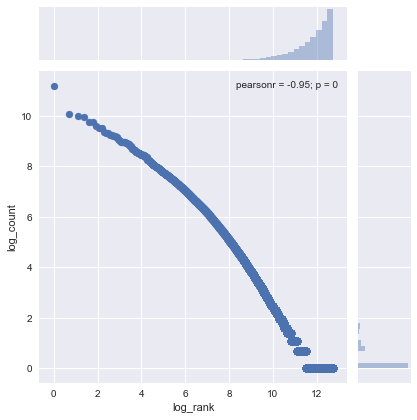

In [21]:
sns.jointplot(x="log_rank", y="log_count", data=tokens_pdf)

# Word2Vec Synonyms

What words are related?


In [22]:
from pyspark.ml.feature import Word2Vec

In [41]:
w2v = Word2Vec(vectorSize=100, 
               minCount=5, 
               numPartitions=4,
               seed=20,
               inputCol="tokens",
               outputCol="result")

In [42]:
w2v.getOrDefault("seed")

20

In [43]:
w2v_model = w2v.fit(comments_tokens)
w2v_vectors = w2v_model.getVectors()

In [44]:
w2v_vectors.count()

42229

In [45]:
w2v_model.findSynonyms('computer', 10).toPandas()

,word,similarity
0,science,0.633247
1,"science,",0.605530
2,science?,0.545220
3,computers,0.538737
4,program,0.534226
5,calculus,0.507490
6,cede,0.496321
7,programmer's,0.493715
8,"program,",0.480995
9,knowledge,0.478143


There's some clean up to be done still. "science", "science,", "science?", and "science." really should all be the same token.

But blindly removing punctuation may not be right for your dataset. What would have happened to ".net", "node.js", and "c#" when we look for synonyms for "java" below? How can you clean up "c++" and "c++,"?

In [46]:
w2v_model.findSynonyms('java', 10).toPandas()

,word,similarity
0,c++,0.786364
1,"java,",0.731301
2,compiled,0.730762
3,jvm,0.718536
4,c#,0.717830
5,.net,0.711414
6,"jvm,",0.696147
7,scala,0.695071
8,c++.,0.693720
9,libraries,0.683583


Hacker News is a site that discusses startups and stories related to technology. Similar to "java" above, the synonyms you get back depend on your training data. Sometimes what you get is intuitive but sometimes you get interesting things like "mouth".

In [47]:
w2v_model.findSynonyms('founder', 10).toPandas()

,word,similarity
0,"professor,",0.674254
1,geologist,0.648628
2,ta,0.640422
3,graduated,0.637239
4,"career,",0.630428
5,interviews,0.624235
6,zuckerberg,0.622673
7,visionary,0.621046
8,harvard,0.616671
9,son,0.611227


So what comments have "founder" and "mouth" in them?

In [48]:
from pyspark.sql.functions import array_contains

comments_tokens\
    .filter(array_contains(comments_tokens["tokens"], "founder"))\
    .filter(array_contains(comments_tokens["tokens"], "mouths"))\
    .select(comments_tokens["comment_text"])\
    .show(3, truncate=False)

+------------+
|comment_text|
+------------+
+------------+



There are none! This is an important lesson. Word2vec is not a measure of co-occurence like TF-IDF and other techniques. We've reduced the high-dimension co-occurence space down to only 200 dimensions and things that don't occurr together may project down to a lower space in a similar way ie have a similar vecor.